In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, multivariate_normal
from SimPEG.utils import mkvc

In [2]:
np.random.seed(12345)

In [3]:
test_location = np.linspace(0,1,100) #random locations

In [4]:
training_location = np.sort(np.random.rand(10))

In [5]:
def truth(x):
    return np.sin(2*np.pi*x)

In [6]:
noise = 0.1

In [7]:
training_data = truth(training_location)+ noise * np.random.randn(training_location.shape[0])
training_data -=training_data.mean()

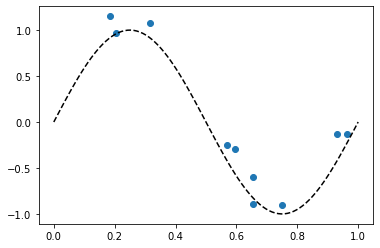

In [8]:
plt.scatter(training_location,training_data)
plt.plot(test_location,truth(test_location),linestyle='--',c='k')

In [9]:
def kernel(a,b,family='rbf',kopts={'variance':1,'length':1,'periodicity':1,'offset':0,'variance_b':1}):
    if family=='rbf':
        return kopts['variance']*np.exp(-0.5*((a-b)/kopts['length'])**2)
    elif family=='periodic':
        return kopts['variance']*np.exp(-2*(np.sin(np.pi*np.abs(a-b)/kopts['periodicity'])/kopts['length'])**2)
    elif family=='linear':
        return kopts['variance_b'] + kopts['variance']*mkvc(a,numDims=2).dot(mkvc(b,numDims=2).T)
    else:
        print('not supported kernel')

In [10]:
def compute_distances(location_a,location_b):

    x = mkvc(location_a, numDims=2)
    y = mkvc(location_b, numDims=2)

    n, d = x.shape
    t, d1 = y.shape

    if not d == d1:
        raise Exception('vectors must have same number of columns')

    sq_dis = np.dot(
        (x**2.),
        np.ones([d, t])
    ) + np.dot(np.ones([n, d]), (y**2.).T) - 2. * np.dot(x, y.T)

    idx = np.argmin(sq_dis, axis=1)

    return sq_dis**0.5

In [11]:
# P(test | obs)

In [12]:
def covariance_matrix(location_a,location_b,family='rbf',kopts={'variance':1,'length':1,'periodicity':1,'offset':0,'variance_b':1}):
    
    if family=='rbf' or family=='periodic':
        distance = compute_distances(location_a,location_b)
        return kernel(distance,np.zeros_like(distance),family=family,kopts=kopts)
    elif family=='linear':
        return kernel(location_a,location_b,family=family,kopts=kopts)
    else:
        print('not supported kernel')

In [13]:
family='rbf'
kopts={'variance':0.1,'length':0.5,'periodicity':0.5,'offset':0.5,'variance_b':0.1}

In [14]:
Sigma = covariance_matrix(test_location,test_location,family=family,kopts=kopts)

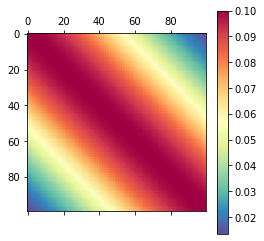

In [15]:
mm = plt.matshow(Sigma,cmap='Spectral_r')
plt.colorbar(mm)
plt.gca().set_aspect(1)

In [16]:
def conditioning(training_location,training_data,test_location,noise_std=noise,family='rbf',kopts={'variance':0.1,'length':0.1,'periodicity':0.5,'offset':0.5,'variance_b':0.1}):
    Sigma_training = covariance_matrix(training_location,training_location,family=family,kopts=kopts)
    Sigma_training += noise_std**2 * np.eye(Sigma_training.shape[0])
    Sigma_training_inv = np.linalg.inv(Sigma_training)
    mean_training = training_data.mean()
    Sigma_test = covariance_matrix(test_location,test_location,family=family,kopts=kopts)
    Sigma_cross = covariance_matrix(test_location,training_location,family=family,kopts=kopts)
    mean_predict = (Sigma_cross.dot(Sigma_training_inv.dot(training_data-mean_training)))
    #mean_predict -= mean_predict.mean()
    Sigma_predict = Sigma_test - (Sigma_cross.dot(Sigma_training_inv.dot(Sigma_cross.T)))
    
    return mean_predict, Sigma_predict

In [17]:
family='rbf'
kopts={'variance':.1,'length':0.1,'periodicity':1,'offset':0.5,'variance_b':0.1}

In [18]:
mean_predict, Sigma_predict = conditioning(
    training_location,training_data,test_location,
    family=family,noise_std=noise,kopts=kopts)

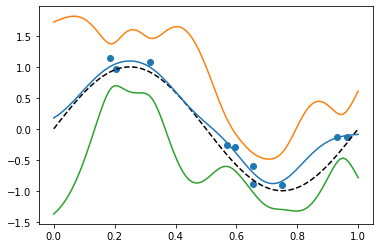

In [19]:
plt.plot(test_location,truth(test_location),linestyle='--',c='k')
plt.plot(test_location,mean_predict)
plt.plot(test_location,mean_predict.flatten()+5*np.sqrt(Sigma_predict.diagonal()))
plt.plot(test_location,mean_predict.flatten()-5*np.sqrt(Sigma_predict.diagonal()))

plt.scatter(training_location,training_data)

#plt.gca().set_ylim([-1.5,1.5])

In [20]:
family='periodic'
kopts={'variance':1,'length':1,'periodicity':1,'offset':0.5,'variance_b':0.1}

In [21]:
mean_predict, Sigma_predict = conditioning(training_location,training_data,test_location,family=family,noise_std=noise,kopts=kopts)

(-1.5, 1.5)

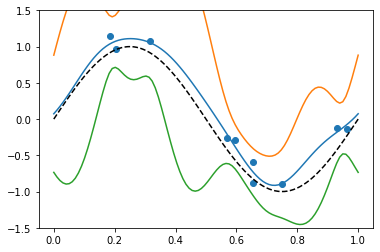

In [22]:
plt.plot(test_location,truth(test_location),linestyle='--',c='k')
plt.plot(test_location,mean_predict)
plt.plot(test_location,mean_predict.flatten()+5*np.sqrt(Sigma_predict.diagonal()))
plt.plot(test_location,mean_predict.flatten()-5*np.sqrt(Sigma_predict.diagonal()))

plt.scatter(training_location,training_data)

plt.gca().set_ylim([-1.5,1.5])

In [23]:
family='periodic'
kopts={'variance':0.5,'length':0.5,'periodicity':1,'offset':0.5,'variance_b':0.1}

In [24]:
mean_predict, Sigma_predict = conditioning(training_location,training_data,test_location,family=family,noise_std=noise,kopts=kopts)

(-1.5, 1.5)

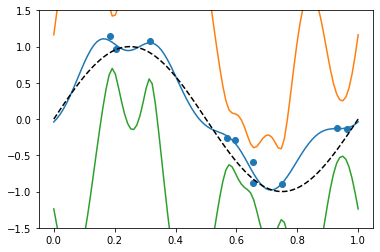

In [25]:
plt.plot(test_location,mean_predict)
plt.plot(test_location,mean_predict.flatten()+5*np.sqrt(Sigma_predict.diagonal()))
plt.plot(test_location,mean_predict.flatten()-5*np.sqrt(Sigma_predict.diagonal()))
plt.plot(test_location,truth(test_location),linestyle='--',c='k')
plt.scatter(training_location,training_data)

plt.gca().set_ylim([-1.5,1.5])

In [26]:
#sampling functions

In [27]:
multi = multivariate_normal(mean_predict, Sigma_predict,allow_singular=True)

(-1.5, 1.5)

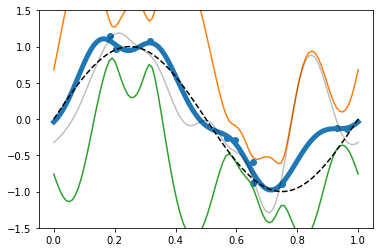

In [28]:
plt.plot(test_location,mean_predict, linewidth=5)
plt.plot(test_location,mean_predict.flatten()+3*np.sqrt(Sigma_predict.diagonal()))
plt.plot(test_location,mean_predict.flatten()-3*np.sqrt(Sigma_predict.diagonal()))
plt.plot(test_location,truth(test_location),linestyle='--',c='k')

#for i in range(20):
plt.plot(test_location,multi.rvs(),c='k',alpha=0.25)

plt.scatter(training_location,training_data)

plt.gca().set_ylim([-1.5,1.5])

### Select best parameters: the concept of training and validation data

In [29]:
# separate data in 5 random set
perm = np.random.permutation(training_data.shape[0])
print(perm)
data_subsets = []
location_subsets = []
index_subsets = []
for i in range(5):
    index = np.ones(10,dtype=bool)
    index[perm[2*i:2*(i+1)]] = 0
    print(index)
    print(index.sum())
    index_subsets.append(index)
    data_subsets.append(training_data[index])
    location_subsets.append(training_location[index])

[9 6 4 1 0 2 8 3 5 7]
[ True  True  True  True  True  True False  True  True False]
8
[ True False  True  True False  True  True  True  True  True]
8
[False  True False  True  True  True  True  True  True  True]
8
[ True  True  True False  True  True  True  True False  True]
8
[ True  True  True  True  True False  True False  True  True]
8


In [30]:
def score_measure(measured, predicted):
    return np.sum((measured-predicted)**2)

## best rbf

In [31]:

family='rbf'
best_score = np.inf
best_params = {'variance':np.inf,'length':np.inf}
for variance in np.logspace(1e-2,1,5):
    for length in np.linspace(0.1,1,5):   
        kopts={'variance':variance,'length':length}
        score = 0
        for i, (datasub, locsub, indx) in enumerate(zip(data_subsets, location_subsets, index_subsets)):
            validation_data = training_data[~indx]
            validation_location = training_location[~indx]
            mean_predict, Sigma_predict = conditioning(
                    locsub,
                    datasub,
                    validation_location,
                    family=family,
                    noise_std=noise,
                    kopts=kopts
            )
            score += score_measure(validation_data,mean_predict)
        if score < best_score:
            best_score = score
            best_params = {'variance':variance,'length':length}
            

In [32]:
print(score)
print(best_params)

0.7489366395979496
{'variance': 1.023292992280754, 'length': 0.325}


(-1.5, 1.5)

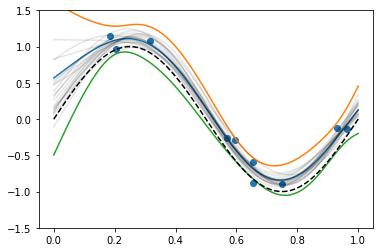

In [33]:
#plot best rbf:
mean_predict, Sigma_predict = conditioning(training_location,training_data,test_location,family=family,noise_std=noise,kopts=best_params)
multi = multivariate_normal(mean_predict, Sigma_predict,allow_singular=True)

plt.plot(test_location,mean_predict)
plt.plot(test_location,mean_predict.flatten()+3*np.sqrt(Sigma_predict.diagonal()))
plt.plot(test_location,mean_predict.flatten()-3*np.sqrt(Sigma_predict.diagonal()))
plt.plot(test_location,truth(test_location),linestyle='--',c='k')

for i in range(20):
    plt.plot(test_location,multi.rvs(),c='k',alpha=0.1)

plt.scatter(training_location,training_data)

plt.gca().set_ylim([-1.5,1.5])

## best periodic

In [34]:

family='periodic'
best_score = np.inf
best_params = {'variance':np.inf,'length':np.inf}
for variance in np.logspace(1e-2,1,5):
    for length in np.linspace(0.1,1,5):
        for period in np.logspace(1e-2,1,5):
            kopts={'variance':variance,'length':length,'periodicity':period}
            score = 0,
            for i, (datasub, locsub, indx) in enumerate(zip(data_subsets, location_subsets, index_subsets)):
                validation_data = training_data[~indx]
                validation_location = training_location[~indx]
                mean_predict, Sigma_predict = conditioning(
                    locsub,
                    datasub,
                    validation_location,
                    family=family,
                    noise_std=noise,
                    kopts=kopts
                )
                score += score_measure(validation_data,mean_predict)
            if score < best_score:
                best_score = score
                best_params = {'variance':variance,'length':length,'periodicity':period}

In [35]:
print(score)
print(best_params)

[0.96961243]
{'variance': 1.023292992280754, 'length': 0.775, 'periodicity': 3.198895109691398}


(-1.5, 1.5)

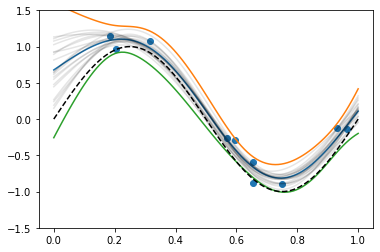

In [36]:
#plot best periodic:
mean_predict, Sigma_predict = conditioning(training_location,training_data,test_location,family=family,noise_std=noise,kopts=best_params)
multi = multivariate_normal(mean_predict, Sigma_predict,allow_singular=True)

plt.plot(test_location,mean_predict)
plt.plot(test_location,mean_predict.flatten()+3*np.sqrt(Sigma_predict.diagonal()))
plt.plot(test_location,mean_predict.flatten()-3*np.sqrt(Sigma_predict.diagonal()))
plt.plot(test_location,truth(test_location),linestyle='--',c='k')

for i in range(20):
    plt.plot(test_location,multi.rvs(),c='k',alpha=0.1)

plt.scatter(training_location,training_data)

plt.gca().set_ylim([-1.5,1.5])

# GP for linear inversion

In [37]:
import numpy as np
import matplotlib.pyplot as plt

from discretize import TensorMesh

from SimPEG import (
    simulation,
    maps,
    data_misfit,
    directives,
    optimization,
    regularization,
    inverse_problem,
    inversion,
    utils
)


(-2.0, 2.0)

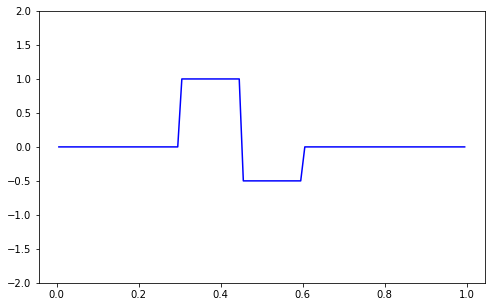

In [38]:
nParam = 100  # Number of model paramters

# A 1D mesh is used to define the row-space of the linear operator.
mesh = TensorMesh([nParam])

# Creating the true model
true_model = np.zeros(mesh.nC)
true_model[mesh.vectorCCx > 0.3] = 1.0
true_model[mesh.vectorCCx > 0.45] = -0.5
true_model[mesh.vectorCCx > 0.6] = 0

# Mapping from the model space to the row space of the linear operator
model_map = maps.IdentityMap(mesh)

# Plotting the true model
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)
ax.plot(mesh.vectorCCx, true_model, "b-")
ax.set_ylim([-2, 2])

Text(0.5, 1.0, 'Columns of matrix G')

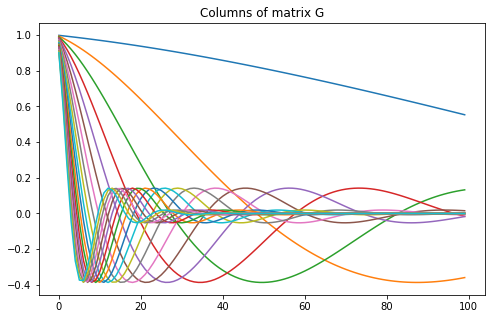

In [39]:
# Number of data observations (rows)
nData = 20

# Create the linear operator for the tutorial. The columns of the linear operator
# represents a set of decaying and oscillating functions.
jk = np.linspace(1.0, 60.0, nData)
p = -0.25
q = 0.25


def g(k):
    return np.exp(p * jk[k] * mesh.vectorCCx) * np.cos(
        np.pi * q * jk[k] * mesh.vectorCCx
    )


G = np.empty((nData, nParam))

for i in range(nData):
    G[i, :] = g(i)

# Plot the columns of G
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)
for i in range(G.shape[0]):
    ax.plot(G[i, :])

ax.set_title("Columns of matrix G")

In [40]:
sim = simulation.LinearSimulation(mesh, G=G, model_map=model_map)

/Users/thibautastic/GITHUB/simpeg/SimPEG/simulation.py:547: UserWarning: G has not been implemented for the simulation
  warnings.warn("G has not been implemented for the simulation")


In [41]:
# Standard deviation of Gaussian noise being added
std = 0.01
np.random.seed(1)

# Create a SimPEG data object
data_obj = sim.make_synthetic_data(true_model, relative_error=std, add_noise=True)

In [42]:
# Define the data misfit. Here the data misfit is the L2 norm of the weighted
# residual between the observed data and the data predicted for a given model.
# Within the data misfit, the residual between predicted and observed data are
# normalized by the data's standard deviation.
dmis = data_misfit.L2DataMisfit(simulation=sim, data=data_obj)

# Define the regularization (model objective function).
reg = regularization.Tikhonov(mesh, alpha_s=1.0, alpha_x=1.0)

# Define how the optimization problem is solved.
opt = optimization.InexactGaussNewton(maxIter=100,tolCG=1e-4, maxIterCG=100)
opt.tolX = 1e-16
opt.tolF = 1e-16
opt.tolG = 1e-16
opt.eps = 1e-16

# Here we define the inverse problem that is to be solved
inv_prob = inverse_problem.BaseInvProblem(dmis, reg, opt)

In [43]:
# Defining a starting value for the trade-off parameter (beta) between the data
# misfit and the regularization.
starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=1e-4)
beta_schedule = directives.BetaSchedule(coolingRate=3,coolingFactor=2)
# Setting a stopping criteria for the inversion.
target_misfit = directives.TargetMisfit()

# The directives are defined as a list.
directives_list = [starting_beta, beta_schedule, target_misfit]

In [44]:
# Here we combine the inverse problem and the set of directives
inv = inversion.BaseInversion(inv_prob, directives_list)

# Starting model
starting_model = np.zeros(nParam)

# Run inversion
recovered_model = inv.run(starting_model)

SimPEG.InvProblem will set Regularization.mref to m0.

        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
        ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.86e+02  1.00e+05  0.00e+00  1.00e+05    1.26e+06      0              
   1  1.86e+02  5.15e+02  1.72e+01  3.71e+03    1.12e+02      0              
   2  1.86e+02  5.10e+02  1.72e+01  3.71e+03    1.39e-04      0   Skip BFGS  
   3  9.30e+01  5.10e+02  1.72e+01  2.11e+03    1.18e+03      0   Skip BFGS  
   4  9.30e+01  1.87e+02  1.96e+01  2.01e+03    5.69e-02      0              
   5  9.30e+01  1.87e+02  1.96e+01  2.01e+03    1.73e-06      0   Skip BFGS  
   6  4.65e+01  1.87e+02  1.96e+01  1.10e+03    6.31e+02  

(-2.0, 2.0)

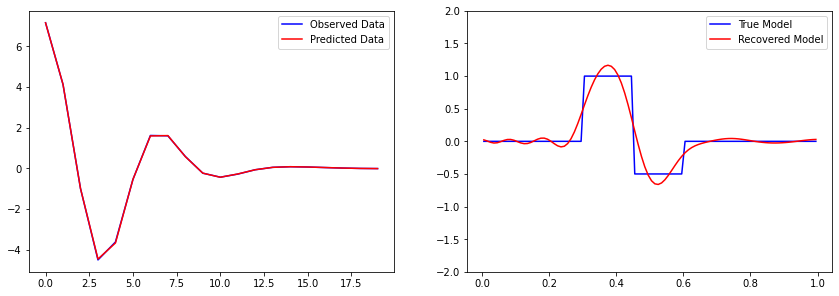

In [45]:
# Observed versus predicted data
fig, ax = plt.subplots(1, 2, figsize=(12 * 1.2, 4 * 1.2))
ax[0].plot(data_obj.dobs, "b-")
ax[0].plot(inv_prob.dpred, "r-")
ax[0].legend(("Observed Data", "Predicted Data"))

# True versus recovered model
ax[1].plot(mesh.vectorCCx, true_model, "b-")
ax[1].plot(mesh.vectorCCx, recovered_model, "r-")
ax[1].legend(("True Model", "Recovered Model"))
ax[1].set_ylim([-2, 2])

In [46]:
(G.T.dot(G)).max()

18.210277812085415

In [47]:
Sigma.max()

0.1

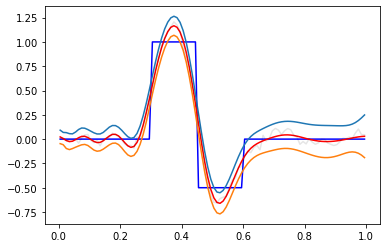

In [50]:
#plot best periodic:
beta = inv_prob.beta
Precision = G.T.dot((dmis.W.T.dot(dmis.W)).dot(G)) + beta * ((reg.W.T.dot(reg.W)).todense())
Sigma = np.linalg.inv(Precision)
multi = multivariate_normal(recovered_model, Sigma,allow_singular=True)

# True versus recovered model
plt.plot(mesh.vectorCCx, true_model, "b-")
plt.plot(mesh.vectorCCx, recovered_model, "r-")
plt.plot(mesh.vectorCCx,np.squeeze(np.asarray(recovered_model+3*np.sqrt(Sigma.diagonal()))))
plt.plot(mesh.vectorCCx,np.squeeze(np.asarray(recovered_model-3*np.sqrt(Sigma.diagonal()))))

model_list = [true_model, recovered_model]

for i in range(20):
    sample_model = multi.rvs()
    plt.plot(mesh.vectorCCx,sample_model,c='k',alpha=0.1)
    model_list.append(sample_model)
    
dmis_list = [dmis(mdl) for mdl in model_list]

In [49]:
dmis_list

[12.016885886196226,
 8.823478010966548,
 13.37319938252876,
 15.48454409160483,
 12.685124563029456,
 20.842910685153658,
 21.779005563891825,
 21.78044223539408,
 12.061699491583715,
 11.42301812594057,
 13.280656124073326,
 17.287260127974704,
 11.189339438810489,
 12.143747715336106,
 20.111103569626586,
 13.745887680780946,
 19.129272934712457,
 12.704503319754673,
 15.21277240078808,
 19.083969149270967,
 14.729986668523875,
 13.028383276294443]